In [14]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Preprocessing

### Import Dataset

In [15]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

gene_id  \
gene_name                     
AC073488.4  ENSG00000282222   
AC119427.1  ENSG00000282221   
MIR543      ENSG00000212040   
MADD        ENSG00000110514   
AL356737.2  ENSG00000287159   

                                                  description  \
gene_name                                                       
AC073488.4  chromodomain protein, Y chromosome-like (CDYL)...   
AC119427.1                novel transcript, antisense to LAD1   
MIR543       microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664]   
MADD        MAP kinase activating death domain [Source:HGN...   
AL356737.2                novel transcript, antisense to GPC5   

                       gene_type                   locus  RNA1_FPKM  \
gene_name                                                             
AC073488.4  processed_pseudogene       X:9410789-9411545   0.000000   
AC119427.1                lncRNA   1:201399633-201401190   0.000000   
MIR543                     miRNA  14:101031987-101032064   0.000000   
MADD              protein_coding    11:47269161-47330031   6.345943   
AL356737.2                lncRNA    13:92610646-92677725   0.000000   

            RNA102_FPKM  RNA104_FPKM  RNA108_FPKM  RNA109_FPKM  RNA110_FPKM  \
gene_name                                                                     
AC073488.4     0.000000     0.000000     0.000000     0.000000     0.000000   
AC119427.1     0.000000     0.000000     0.000000     0.000000     0.000000   
MIR543         0.000000     0.000000     0.000000     0.000000     0.962816   
MADD           8.482109    10.209322     7.143557     5.671481     7.776351   
AL356737.2     0.000000     0.000000     0.000000     0.000000     0.000000   

            ...  R_JS032_count  R_JS033_count  R_JS034_count  R_JS035_count  \
gene_name   ...                                                               
AC073488.4  ...              0              0              0              0   
AC119427.1  ...              0              0              0              0   
MIR543      ...              0              0              0              0   
MADD        ...           1187           1254           1767           1184   
AL356737.2  ...              0              0              0              0   

            R_JS036_count  R_JS037_count  R_JS038_count  R_JS039_count  \
gene_name                                                                
AC073488.4              0              0              1              0   
AC119427.1              0              0              0              0   
MIR543                  0              0              0              0   
MADD                 2418           1294           1254           1461   
AL356737.2              0              0              0              0   

            R_JS040_count  R_JS041_count  
gene_name                                 
AC073488.4              0              0  
AC119427.1              0              0  
MIR543                  0              0  
MADD                 1323           1795  
AL356737.2              0              0  

[5 rows x 390 columns]

### Check Gene Types

In [16]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [17]:
df = df[df['gene_type'] == 'processed_pseudogene']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset07/data0.csv')

### Combine with Diagnosis

In [18]:
df = pd.read_csv('../Datasets/Dataset07/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset07/data1.csv')

df.head()

AC073488.4   EIF4EP1  ZBTB45P1  DPY19L2P5   KRT8P15   RPL22P3  \
RNA1_FPKM           0.0  2.227354       0.0        0.0  0.000000  0.417020   
RNA102_FPKM         0.0  3.521613       0.0        0.0  0.363572  0.395553   
RNA104_FPKM         0.0  4.496969       0.0        0.0  0.000000  0.971489   
RNA108_FPKM         0.0  7.640363       0.0        0.0  0.000000  0.210989   
RNA109_FPKM         0.0  3.611940       0.0        0.0  0.000000  1.049406   

             FAM133CP  AC100810.6  MTND5P42  SLC25A5P9  ...   RBBP4P1  \
RNA1_FPKM    0.000000         0.0  0.000000        0.0  ...  3.237396   
RNA102_FPKM  0.214071         0.0  0.000000        0.0  ...  3.720855   
RNA104_FPKM  1.051526         0.0  0.297363        0.0  ...  3.074783   
RNA108_FPKM  0.114186         0.0  0.000000        0.0  ...  2.709793   
RNA109_FPKM  0.227150         0.0  0.000000        0.0  ...  2.005310   

             AL445305.1   ALDOAP2  RPL38P3  KSR1P1  ARHGAP42P3  AC104454.1  \
RNA1_FPKM      1.934247  0.000000      0.0     0.0         0.0         0.0   
RNA102_FPKM    1.310611  0.000000      0.0     0.0         0.0         0.0   
RNA104_FPKM    0.772488  0.137627      0.0     0.0         0.0         0.0   
RNA108_FPKM    1.118821  0.074709      0.0     0.0         0.0         0.0   
RNA109_FPKM    1.390691  0.000000      0.0     0.0         0.0         0.0   

                 RPL9P7  AC098657.1  Diagnosis  
RNA1_FPKM    877.823039         0.0          1  
RNA102_FPKM  469.711471         0.0          2  
RNA104_FPKM  353.414458         0.0          1  
RNA108_FPKM  523.365561         0.0          1  
RNA109_FPKM  594.201824         0.0          0  

[5 rows x 10163 columns]

### Remove Patients who hasn't Diabetic

In [19]:
df = pd.read_csv('../Datasets/Dataset07/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset07/data2.csv")
df.head()

AC073488.4   EIF4EP1  ZBTB45P1  DPY19L2P5   KRT8P15   RPL22P3  \
RNA1_FPKM           0.0  2.227354       0.0        0.0  0.000000  0.417020   
RNA102_FPKM         0.0  3.521613       0.0        0.0  0.363572  0.395553   
RNA104_FPKM         0.0  4.496969       0.0        0.0  0.000000  0.971489   
RNA108_FPKM         0.0  7.640363       0.0        0.0  0.000000  0.210989   
RNA110_FPKM         0.0  1.755089       0.0        0.0  0.000000  0.197112   

             FAM133CP  AC100810.6  MTND5P42  SLC25A5P9  ...   RBBP4P1  \
RNA1_FPKM    0.000000         0.0  0.000000        0.0  ...  3.237396   
RNA102_FPKM  0.214071         0.0  0.000000        0.0  ...  3.720855   
RNA104_FPKM  1.051526         0.0  0.297363        0.0  ...  3.074783   
RNA108_FPKM  0.114186         0.0  0.000000        0.0  ...  2.709793   
RNA110_FPKM  0.106676         0.0  0.000000        0.0  ...  1.942660   

             AL445305.1   ALDOAP2  RPL38P3  KSR1P1  ARHGAP42P3  AC104454.1  \
RNA1_FPKM      1.934247  0.000000      0.0     0.0         0.0         0.0   
RNA102_FPKM    1.310611  0.000000      0.0     0.0         0.0         0.0   
RNA104_FPKM    0.772488  0.137627      0.0     0.0         0.0         0.0   
RNA108_FPKM    1.118821  0.074709      0.0     0.0         0.0         0.0   
RNA110_FPKM    1.567653  0.000000      0.0     0.0         0.0         0.0   

                 RPL9P7  AC098657.1  Diagnosis  
RNA1_FPKM    877.823039         0.0          0  
RNA102_FPKM  469.711471         0.0          1  
RNA104_FPKM  353.414458         0.0          0  
RNA108_FPKM  523.365561         0.0          0  
RNA110_FPKM  838.965417         0.0          0  

[5 rows x 10163 columns]

### Analyze the Dataset

In [20]:
df = pd.read_csv("../Datasets/Dataset07/data2.csv", index_col=0)
df.describe()

AC073488.4     EIF4EP1    ZBTB45P1   DPY19L2P5     KRT8P15     RPL22P3  \
count  143.000000  143.000000  143.000000  143.000000  143.000000  143.000000   
mean     0.006414    4.037029    0.012545    0.004640    0.047073    0.503184   
std      0.036315    2.344771    0.056962    0.032174    0.081731    0.482930   
min      0.000000    0.350719    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    2.243284    0.000000    0.000000    0.000000    0.200251   
50%      0.000000    3.677923    0.000000    0.000000    0.000000    0.403041   
75%      0.000000    5.211994    0.000000    0.000000    0.084064    0.713977   
max      0.362897   14.828464    0.565965    0.244970    0.374870    3.280053   

         FAM133CP  AC100810.6    MTND5P42   SLC25A5P9  ...     RBBP4P1  \
count  143.000000       143.0  143.000000  143.000000  ...  143.000000   
mean     0.334115         0.0    0.007306    0.001912  ...    2.495034   
std      0.324408         0.0    0.067108    0.022860  ...    1.120669   
min      0.000000         0.0    0.000000    0.000000  ...    0.610392   
25%      0.110512         0.0    0.000000    0.000000  ...    1.732687   
50%      0.255437         0.0    0.000000    0.000000  ...    2.311167   
75%      0.437761         0.0    0.000000    0.000000  ...    2.988616   
max      2.219773         0.0    0.747462    0.273369  ...    7.317048   

       AL445305.1     ALDOAP2  RPL38P3      KSR1P1  ARHGAP42P3  AC104454.1  \
count  143.000000  143.000000    143.0  143.000000       143.0       143.0   
mean     1.313401    0.120855      0.0    0.002215         0.0         0.0   
std      0.637361    0.176089      0.0    0.026489         0.0         0.0   
min      0.360064    0.000000      0.0    0.000000         0.0         0.0   
25%      0.841010    0.000000      0.0    0.000000         0.0         0.0   
50%      1.165691    0.070899      0.0    0.000000         0.0         0.0   
75%      1.666761    0.156982      0.0    0.000000         0.0         0.0   
max      3.141530    1.001698      0.0    0.316762         0.0         0.0   

            RPL9P7  AC098657.1   Diagnosis  
count   143.000000       143.0  143.000000  
mean    736.311762         0.0    0.468531  
std     302.088662         0.0    0.500763  
min     233.345139         0.0    0.000000  
25%     515.400776         0.0    0.000000  
50%     684.498613         0.0    0.000000  
75%     873.508358         0.0    1.000000  
max    1754.276795         0.0    1.000000  

[8 rows x 10163 columns]

In [21]:
df.dtypes

AC073488.4    float64
EIF4EP1       float64
ZBTB45P1      float64
DPY19L2P5     float64
KRT8P15       float64
               ...   
ARHGAP42P3    float64
AC104454.1    float64
RPL9P7        float64
AC098657.1    float64
Diagnosis       int64
Length: 10163, dtype: object

In [22]:
df.isnull().sum()

AC073488.4    0
EIF4EP1       0
ZBTB45P1      0
DPY19L2P5     0
KRT8P15       0
             ..
ARHGAP42P3    0
AC104454.1    0
RPL9P7        0
AC098657.1    0
Diagnosis     0
Length: 10163, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [23]:
df = pd.read_csv("../Datasets/Dataset07/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    7    15    16 ... 10158 10159 10161] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    7    15    16 ... 10158 10159 10161] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    7    15    16 ... 10158 101

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.53+/-0.09
1   Information Gain (Mutual info)            50            0.53+/-0.09
2   Information Gain (Mutual info)           100            0.53+/-0.09
3   Information Gain (Mutual info)           150            0.53+/-0.09
4   Information Gain (Mutual info)           200            0.53+/-0.09
5          Correlation Coefficient            25            0.53+/-0.09
6          Correlation Coefficient            50            0.53+/-0.09
7          Correlation Coefficient           100            0.53+/-0.09
8          Correlation Coefficient           150            0.53+/-0.09
9          Correlation Coefficient           200            0.53+/-0.09
10                      Chi-Square            25            0.53+/-0.09
11                      Chi-Square            50            0.53+/-0.09
12                      Chi-Square           100            0.53

### Check Feature Importance

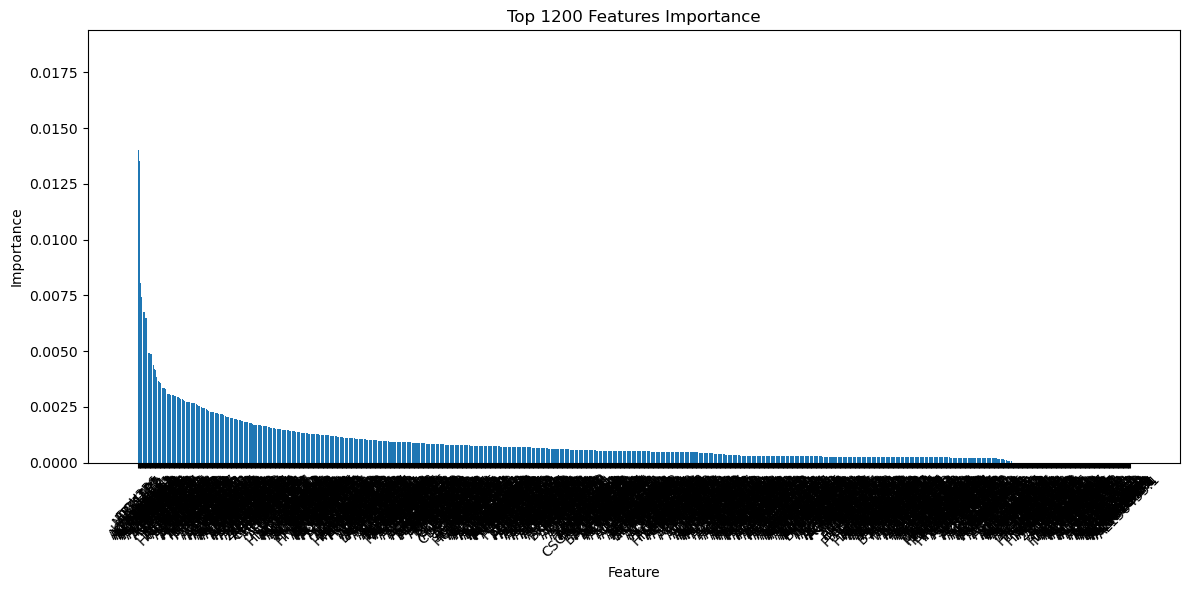

Last important feature:  1057


In [24]:
df = pd.read_csv("../Datasets/Dataset07/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [1200]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [25]:
df = pd.read_csv("../Datasets/Dataset07/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset07/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [28]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in feature_counts:
    file_path = f"../Datasets/Dataset07/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset07/Feature_Select/results.csv", index=False)

SVM(linear) with 1 features: 0.7379 +/- 0.0640
SVM(poly) with 1 features: 0.7793 +/- 0.0516
Naive Bayes with 1 features: 0.7724 +/- 0.0601
Logistic Regression with 1 features: 0.7379 +/- 0.0601
ANN with 1 features: 0.7517 +/- 0.0736
Random Forest with 1 features: 0.7103 +/- 0.0640
XGBoost with 1 features: 0.7103 +/- 0.0640
SVM(linear) with 2 features: 0.7655 +/- 0.0669
SVM(poly) with 2 features: 0.7448 +/- 0.0774
Naive Bayes with 2 features: 0.7862 +/- 0.0552
Logistic Regression with 2 features: 0.7724 +/- 0.0560


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


ANN with 2 features: 0.7793 +/- 0.0560
Random Forest with 2 features: 0.7586 +/- 0.0816
XGBoost with 2 features: 0.7310 +/- 0.1009
SVM(linear) with 3 features: 0.7655 +/- 0.0669
SVM(poly) with 3 features: 0.7379 +/- 0.0833
Naive Bayes with 3 features: 0.7724 +/- 0.0676
Logistic Regression with 3 features: 0.7655 +/- 0.0669


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


ANN with 3 features: 0.7517 +/- 0.0669
Random Forest with 3 features: 0.7724 +/- 0.0710
XGBoost with 3 features: 0.7034 +/- 0.0966
SVM(linear) with 4 features: 0.7655 +/- 0.0669
SVM(poly) with 4 features: 0.7448 +/- 0.0941
Naive Bayes with 4 features: 0.7793 +/- 0.0833
Logistic Regression with 4 features: 0.7655 +/- 0.0669
ANN with 4 features: 0.4483 +/- 0.0534
Random Forest with 4 features: 0.7862 +/- 0.0910
XGBoost with 4 features: 0.7379 +/- 0.0710
SVM(linear) with 5 features: 0.7655 +/- 0.0669
SVM(poly) with 5 features: 0.7448 +/- 0.0941
Naive Bayes with 5 features: 0.8138 +/- 0.0468
Logistic Regression with 5 features: 0.7655 +/- 0.0669
ANN with 5 features: 0.4483 +/- 0.0534
Random Forest with 5 features: 0.7724 +/- 0.0640
XGBoost with 5 features: 0.7310 +/- 0.0856
SVM(linear) with 6 features: 0.7931 +/- 0.0577
SVM(poly) with 6 features: 0.7448 +/- 0.0941
Naive Bayes with 6 features: 0.8000 +/- 0.0736
Logistic Regression with 6 features: 0.7793 +/- 0.0560


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer

ANN with 6 features: 0.7931 +/- 0.0488
Random Forest with 6 features: 0.7724 +/- 0.0833
XGBoost with 6 features: 0.7586 +/- 0.0755
SVM(linear) with 7 features: 0.7862 +/- 0.0593
SVM(poly) with 7 features: 0.7448 +/- 0.0941
Naive Bayes with 7 features: 0.8069 +/- 0.0601
Logistic Regression with 7 features: 0.7724 +/- 0.0468
ANN with 7 features: 0.4483 +/- 0.0534
Random Forest with 7 features: 0.7724 +/- 0.0560
XGBoost with 7 features: 0.7448 +/- 0.0516
SVM(linear) with 8 features: 0.7862 +/- 0.0593
SVM(poly) with 8 features: 0.7448 +/- 0.0941
Naive Bayes with 8 features: 0.8000 +/- 0.0507
Logistic Regression with 8 features: 0.7862 +/- 0.0507
ANN with 8 features: 0.4483 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 8 features: 0.7793 +/- 0.0640
XGBoost with 8 features: 0.7379 +/- 0.0601
SVM(linear) with 9 features: 0.7586 +/- 0.0378
SVM(poly) with 9 features: 0.6414 +/- 0.0516
Naive Bayes with 9 features: 0.8000 +/- 0.0507
Logistic Regression with 9 features: 0.7586 +/- 0.0378


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 9 features: 0.7034 +/- 0.1103
Random Forest with 9 features: 0.8069 +/- 0.0601
XGBoost with 9 features: 0.7241 +/- 0.1046
SVM(linear) with 10 features: 0.7724 +/- 0.0468
SVM(poly) with 10 features: 0.6414 +/- 0.0516
Naive Bayes with 10 features: 0.8000 +/- 0.0593
Logistic Regression with 10 features: 0.7517 +/- 0.0402
ANN with 10 features: 0.5655 +/- 0.0804


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 10 features: 0.7517 +/- 0.0507
XGBoost with 10 features: 0.7379 +/- 0.1125
SVM(linear) with 11 features: 0.7655 +/- 0.0736
SVM(poly) with 11 features: 0.6414 +/- 0.0516
Naive Bayes with 11 features: 0.8207 +/- 0.0402
Logistic Regression with 11 features: 0.7517 +/- 0.0402


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 11 features: 0.7655 +/- 0.0883
Random Forest with 11 features: 0.7862 +/- 0.0593
XGBoost with 11 features: 0.7172 +/- 0.0828
SVM(linear) with 12 features: 0.7724 +/- 0.0468
SVM(poly) with 12 features: 0.6414 +/- 0.0516
Naive Bayes with 12 features: 0.8138 +/- 0.0516
Logistic Regression with 12 features: 0.7448 +/- 0.0352
ANN with 12 features: 0.4483 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 12 features: 0.7793 +/- 0.0833
XGBoost with 12 features: 0.7310 +/- 0.0883
SVM(linear) with 13 features: 0.7517 +/- 0.0669
SVM(poly) with 13 features: 0.6414 +/- 0.0516
Naive Bayes with 13 features: 0.8138 +/- 0.0516


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 13 features: 0.7379 +/- 0.0276
ANN with 13 features: 0.6552 +/- 0.0899
Random Forest with 13 features: 0.7862 +/- 0.0856
XGBoost with 13 features: 0.7379 +/- 0.1082
SVM(linear) with 14 features: 0.7379 +/- 0.0352
SVM(poly) with 14 features: 0.6414 +/- 0.0516
Naive Bayes with 14 features: 0.8069 +/- 0.0560
Logistic Regression with 14 features: 0.7379 +/- 0.0352


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 14 features: 0.7379 +/- 0.0516
Random Forest with 14 features: 0.8069 +/- 0.0601
XGBoost with 14 features: 0.7448 +/- 0.0743
SVM(linear) with 15 features: 0.7586 +/- 0.0577
SVM(poly) with 15 features: 0.6414 +/- 0.0516
Naive Bayes with 15 features: 0.8207 +/- 0.0402
Logistic Regression with 15 features: 0.7448 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 15 features: 0.6828 +/- 0.0402
Random Forest with 15 features: 0.7862 +/- 0.0703
XGBoost with 15 features: 0.7241 +/- 0.0786
SVM(linear) with 16 features: 0.7586 +/- 0.0723
SVM(poly) with 16 features: 0.6414 +/- 0.0516
Naive Bayes with 16 features: 0.8276 +/- 0.0308
Logistic Regression with 16 features: 0.7448 +/- 0.0352
ANN with 16 features: 0.5517 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 16 features: 0.8000 +/- 0.0593
XGBoost with 16 features: 0.7448 +/- 0.0804
SVM(linear) with 17 features: 0.7586 +/- 0.0654
SVM(poly) with 17 features: 0.6414 +/- 0.0516
Naive Bayes with 17 features: 0.8276 +/- 0.0308
Logistic Regression with 17 features: 0.7517 +/- 0.0338


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 17 features: 0.7034 +/- 0.1489
Random Forest with 17 features: 0.7862 +/- 0.0703
XGBoost with 17 features: 0.7655 +/- 0.0593
SVM(linear) with 18 features: 0.7655 +/- 0.0338
SVM(poly) with 18 features: 0.6414 +/- 0.0516
Naive Bayes with 18 features: 0.8276 +/- 0.0308
Logistic Regression with 18 features: 0.7517 +/- 0.0338
ANN with 18 features: 0.5517 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 18 features: 0.8069 +/- 0.0468
XGBoost with 18 features: 0.7310 +/- 0.1055
SVM(linear) with 19 features: 0.7655 +/- 0.0258
SVM(poly) with 19 features: 0.6414 +/- 0.0516
Naive Bayes with 19 features: 0.8276 +/- 0.0218
Logistic Regression with 19 features: 0.7310 +/- 0.0258
ANN with 19 features: 0.5517 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 19 features: 0.7862 +/- 0.0552
XGBoost with 19 features: 0.7379 +/- 0.0710
SVM(linear) with 20 features: 0.7655 +/- 0.0552
SVM(poly) with 20 features: 0.6414 +/- 0.0516
Naive Bayes with 20 features: 0.8207 +/- 0.0338
Logistic Regression with 20 features: 0.7517 +/- 0.0338
ANN with 20 features: 0.5517 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 20 features: 0.8138 +/- 0.0516
XGBoost with 20 features: 0.7724 +/- 0.0640
SVM(linear) with 21 features: 0.7655 +/- 0.0703
SVM(poly) with 21 features: 0.6414 +/- 0.0516
Naive Bayes with 21 features: 0.8207 +/- 0.0402
Logistic Regression with 21 features: 0.7517 +/- 0.0402
ANN with 21 features: 0.4483 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 21 features: 0.8276 +/- 0.0577
XGBoost with 21 features: 0.7862 +/- 0.0736
SVM(linear) with 22 features: 0.7793 +/- 0.0352
SVM(poly) with 22 features: 0.6414 +/- 0.0516
Naive Bayes with 22 features: 0.8138 +/- 0.0414
Logistic Regression with 22 features: 0.7586 +/- 0.0378


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 22 features: 0.6759 +/- 0.1858
Random Forest with 22 features: 0.7862 +/- 0.0507
XGBoost with 22 features: 0.7448 +/- 0.0833
SVM(linear) with 23 features: 0.7724 +/- 0.0352
SVM(poly) with 23 features: 0.6414 +/- 0.0516
Naive Bayes with 23 features: 0.8207 +/- 0.0402
Logistic Regression with 23 features: 0.7517 +/- 0.0457


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 23 features: 0.6966 +/- 0.0961
Random Forest with 23 features: 0.8138 +/- 0.0352
XGBoost with 23 features: 0.7517 +/- 0.0798
SVM(linear) with 24 features: 0.7793 +/- 0.0601
SVM(poly) with 24 features: 0.6414 +/- 0.0516
Naive Bayes with 24 features: 0.8207 +/- 0.0402
Logistic Regression with 24 features: 0.7655 +/- 0.0507
ANN with 24 features: 0.5517 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 24 features: 0.8069 +/- 0.0352
XGBoost with 24 features: 0.7655 +/- 0.0593
SVM(linear) with 25 features: 0.7655 +/- 0.0507
SVM(poly) with 25 features: 0.6414 +/- 0.0516
Naive Bayes with 25 features: 0.8207 +/- 0.0402
Logistic Regression with 25 features: 0.7655 +/- 0.0258


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 25 features: 0.7241 +/- 0.0786
Random Forest with 25 features: 0.8069 +/- 0.0468
XGBoost with 25 features: 0.7655 +/- 0.0669
SVM(linear) with 26 features: 0.7448 +/- 0.0560
SVM(poly) with 26 features: 0.6414 +/- 0.0516
Naive Bayes with 26 features: 0.8138 +/- 0.0352
Logistic Regression with 26 features: 0.7517 +/- 0.0338


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 26 features: 0.7862 +/- 0.0258
Random Forest with 26 features: 0.7931 +/- 0.0436
XGBoost with 26 features: 0.7517 +/- 0.0669
SVM(linear) with 27 features: 0.7448 +/- 0.0560
SVM(poly) with 27 features: 0.6414 +/- 0.0516
Naive Bayes with 27 features: 0.8138 +/- 0.0352
Logistic Regression with 27 features: 0.7724 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 27 features: 0.5517 +/- 0.0534
Random Forest with 27 features: 0.8000 +/- 0.0338
XGBoost with 27 features: 0.7586 +/- 0.0617
SVM(linear) with 28 features: 0.7586 +/- 0.0378
SVM(poly) with 28 features: 0.6414 +/- 0.0516
Naive Bayes with 28 features: 0.8138 +/- 0.0352
Logistic Regression with 28 features: 0.7655 +/- 0.0402


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 28 features: 0.7586 +/- 0.0308
Random Forest with 28 features: 0.7931 +/- 0.0378
XGBoost with 28 features: 0.7793 +/- 0.0743
SVM(linear) with 29 features: 0.7862 +/- 0.0798
SVM(poly) with 29 features: 0.6414 +/- 0.0516
Naive Bayes with 29 features: 0.8138 +/- 0.0352
Logistic Regression with 29 features: 0.7862 +/- 0.0402


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 29 features: 0.5517 +/- 0.0617
Random Forest with 29 features: 0.7793 +/- 0.0468
XGBoost with 29 features: 0.7793 +/- 0.0710
SVM(linear) with 30 features: 0.7655 +/- 0.0507
SVM(poly) with 30 features: 0.6414 +/- 0.0516
Naive Bayes with 30 features: 0.8138 +/- 0.0352
Logistic Regression with 30 features: 0.7862 +/- 0.0593


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 30 features: 0.7655 +/- 0.0593
Random Forest with 30 features: 0.7862 +/- 0.0457
XGBoost with 30 features: 0.7862 +/- 0.0736
SVM(linear) with 31 features: 0.7862 +/- 0.0457
SVM(poly) with 31 features: 0.6414 +/- 0.0516
Naive Bayes with 31 features: 0.8138 +/- 0.0352
Logistic Regression with 31 features: 0.7793 +/- 0.0516


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 31 features: 0.6966 +/- 0.0910
Random Forest with 31 features: 0.7862 +/- 0.0457
XGBoost with 31 features: 0.7793 +/- 0.0710
SVM(linear) with 32 features: 0.7724 +/- 0.0560
SVM(poly) with 32 features: 0.6414 +/- 0.0516
Naive Bayes with 32 features: 0.8138 +/- 0.0352
Logistic Regression with 32 features: 0.7931 +/- 0.0308


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 32 features: 0.8138 +/- 0.0276
Random Forest with 32 features: 0.7931 +/- 0.0488
XGBoost with 32 features: 0.7724 +/- 0.0774
SVM(linear) with 33 features: 0.7517 +/- 0.0828
SVM(poly) with 33 features: 0.6414 +/- 0.0516
Naive Bayes with 33 features: 0.8138 +/- 0.0352


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 33 features: 0.7931 +/- 0.0436
ANN with 33 features: 0.4483 +/- 0.0534
Random Forest with 33 features: 0.7931 +/- 0.0488
XGBoost with 33 features: 0.7724 +/- 0.0774
SVM(linear) with 34 features: 0.7655 +/- 0.0593
SVM(poly) with 34 features: 0.6414 +/- 0.0516
Naive Bayes with 34 features: 0.8138 +/- 0.0352
Logistic Regression with 34 features: 0.7862 +/- 0.0402


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 34 features: 0.7793 +/- 0.0468
Random Forest with 34 features: 0.7862 +/- 0.0552
XGBoost with 34 features: 0.7724 +/- 0.0601
SVM(linear) with 35 features: 0.7517 +/- 0.0798
SVM(poly) with 35 features: 0.6414 +/- 0.0516
Naive Bayes with 35 features: 0.8138 +/- 0.0352
Logistic Regression with 35 features: 0.7862 +/- 0.0402


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 35 features: 0.6828 +/- 0.0961
Random Forest with 35 features: 0.7931 +/- 0.0488
XGBoost with 35 features: 0.7655 +/- 0.0507
SVM(linear) with 36 features: 0.7448 +/- 0.0640
SVM(poly) with 36 features: 0.6414 +/- 0.0516
Naive Bayes with 36 features: 0.8138 +/- 0.0352
Logistic Regression with 36 features: 0.7793 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 36 features: 0.5310 +/- 0.0676
Random Forest with 36 features: 0.8000 +/- 0.0338
XGBoost with 36 features: 0.7586 +/- 0.0488
SVM(linear) with 37 features: 0.7517 +/- 0.0593
SVM(poly) with 37 features: 0.6414 +/- 0.0516
Naive Bayes with 37 features: 0.8069 +/- 0.0414
Logistic Regression with 37 features: 0.8000 +/- 0.0552
ANN with 37 features: 0.5517 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 37 features: 0.8000 +/- 0.0402
XGBoost with 37 features: 0.7586 +/- 0.0488
SVM(linear) with 38 features: 0.7448 +/- 0.0710
SVM(poly) with 38 features: 0.6414 +/- 0.0516
Naive Bayes with 38 features: 0.7931 +/- 0.0436
Logistic Regression with 38 features: 0.7862 +/- 0.0402
ANN with 38 features: 0.5931 +/- 0.1420


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 38 features: 0.8000 +/- 0.0402
XGBoost with 38 features: 0.7793 +/- 0.0710
SVM(linear) with 39 features: 0.7655 +/- 0.0552
SVM(poly) with 39 features: 0.6414 +/- 0.0516
Naive Bayes with 39 features: 0.7931 +/- 0.0436
Logistic Regression with 39 features: 0.7793 +/- 0.0516


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 39 features: 0.6138 +/- 0.0703
Random Forest with 39 features: 0.8000 +/- 0.0338
XGBoost with 39 features: 0.7793 +/- 0.0710
SVM(linear) with 40 features: 0.7655 +/- 0.0552
SVM(poly) with 40 features: 0.6414 +/- 0.0516
Naive Bayes with 40 features: 0.7931 +/- 0.0436
Logistic Regression with 40 features: 0.7862 +/- 0.0457


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 40 features: 0.6966 +/- 0.1009
Random Forest with 40 features: 0.7931 +/- 0.0488
XGBoost with 40 features: 0.7655 +/- 0.0703
SVM(linear) with 41 features: 0.7724 +/- 0.0516
SVM(poly) with 41 features: 0.6414 +/- 0.0516
Naive Bayes with 41 features: 0.7862 +/- 0.0507
Logistic Regression with 41 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 41 features: 0.6138 +/- 0.1222
Random Forest with 41 features: 0.8000 +/- 0.0632
XGBoost with 41 features: 0.7793 +/- 0.0676
SVM(linear) with 42 features: 0.7793 +/- 0.0468
SVM(poly) with 42 features: 0.6414 +/- 0.0516
Naive Bayes with 42 features: 0.7862 +/- 0.0507
Logistic Regression with 42 features: 0.7862 +/- 0.0402


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 42 features: 0.7103 +/- 0.0352
Random Forest with 42 features: 0.8000 +/- 0.0457
XGBoost with 42 features: 0.7793 +/- 0.0710
SVM(linear) with 43 features: 0.7448 +/- 0.0833
SVM(poly) with 43 features: 0.6414 +/- 0.0516
Naive Bayes with 43 features: 0.7862 +/- 0.0507
Logistic Regression with 43 features: 0.7931 +/- 0.0436


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 43 features: 0.5103 +/- 0.1298
Random Forest with 43 features: 0.7862 +/- 0.0593
XGBoost with 43 features: 0.8000 +/- 0.0552
SVM(linear) with 44 features: 0.7793 +/- 0.0640
SVM(poly) with 44 features: 0.6414 +/- 0.0516
Naive Bayes with 44 features: 0.7793 +/- 0.0468
Logistic Regression with 44 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 44 features: 0.5379 +/- 0.1337
Random Forest with 44 features: 0.7862 +/- 0.0552
XGBoost with 44 features: 0.8000 +/- 0.0552
SVM(linear) with 45 features: 0.7724 +/- 0.0352
SVM(poly) with 45 features: 0.6414 +/- 0.0516
Naive Bayes with 45 features: 0.7793 +/- 0.0468
Logistic Regression with 45 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 45 features: 0.6966 +/- 0.0507
Random Forest with 45 features: 0.7655 +/- 0.0593
XGBoost with 45 features: 0.8069 +/- 0.0640
SVM(linear) with 46 features: 0.7655 +/- 0.0402
SVM(poly) with 46 features: 0.6414 +/- 0.0516
Naive Bayes with 46 features: 0.7793 +/- 0.0468
Logistic Regression with 46 features: 0.8000 +/- 0.0402


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 46 features: 0.6621 +/- 0.1437
Random Forest with 46 features: 0.8000 +/- 0.0507
XGBoost with 46 features: 0.7931 +/- 0.0577
SVM(linear) with 47 features: 0.7862 +/- 0.0402
SVM(poly) with 47 features: 0.6414 +/- 0.0516
Naive Bayes with 47 features: 0.7793 +/- 0.0468
Logistic Regression with 47 features: 0.7724 +/- 0.0352


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 47 features: 0.6207 +/- 0.0925
Random Forest with 47 features: 0.8069 +/- 0.0352
XGBoost with 47 features: 0.7931 +/- 0.0786
SVM(linear) with 48 features: 0.7862 +/- 0.0402
SVM(poly) with 48 features: 0.6414 +/- 0.0516
Naive Bayes with 48 features: 0.7793 +/- 0.0468
Logistic Regression with 48 features: 0.7862 +/- 0.0507


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 48 features: 0.7448 +/- 0.0833
Random Forest with 48 features: 0.7793 +/- 0.0516
XGBoost with 48 features: 0.7931 +/- 0.0786
SVM(linear) with 49 features: 0.7655 +/- 0.0703
SVM(poly) with 49 features: 0.6414 +/- 0.0516
Naive Bayes with 49 features: 0.7862 +/- 0.0669
Logistic Regression with 49 features: 0.8276 +/- 0.0436


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 49 features: 0.6552 +/- 0.1090
Random Forest with 49 features: 0.7862 +/- 0.0593
XGBoost with 49 features: 0.7862 +/- 0.0669
SVM(linear) with 50 features: 0.7793 +/- 0.0676
SVM(poly) with 50 features: 0.6414 +/- 0.0516
Naive Bayes with 50 features: 0.7862 +/- 0.0669
Logistic Regression with 50 features: 0.8138 +/- 0.0601
ANN with 50 features: 0.5793 +/- 0.1077


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 50 features: 0.8000 +/- 0.0402
XGBoost with 50 features: 0.7862 +/- 0.0669
SVM(linear) with 51 features: 0.7862 +/- 0.0798
SVM(poly) with 51 features: 0.6414 +/- 0.0516
Naive Bayes with 51 features: 0.7862 +/- 0.0669
Logistic Regression with 51 features: 0.8069 +/- 0.0601


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 51 features: 0.7034 +/- 0.1355
Random Forest with 51 features: 0.7793 +/- 0.0516
XGBoost with 51 features: 0.7793 +/- 0.0710
SVM(linear) with 52 features: 0.7862 +/- 0.0593
SVM(poly) with 52 features: 0.6414 +/- 0.0516
Naive Bayes with 52 features: 0.7793 +/- 0.0601
Logistic Regression with 52 features: 0.8138 +/- 0.0560


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 52 features: 0.7724 +/- 0.0169
Random Forest with 52 features: 0.8138 +/- 0.0352
XGBoost with 52 features: 0.7793 +/- 0.0710
SVM(linear) with 53 features: 0.7724 +/- 0.0710
SVM(poly) with 53 features: 0.6414 +/- 0.0516
Naive Bayes with 53 features: 0.7793 +/- 0.0601
Logistic Regression with 53 features: 0.8069 +/- 0.0601


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 53 features: 0.6759 +/- 0.1655
Random Forest with 53 features: 0.7931 +/- 0.0617
XGBoost with 53 features: 0.7724 +/- 0.0601
SVM(linear) with 54 features: 0.7724 +/- 0.0889
SVM(poly) with 54 features: 0.6414 +/- 0.0516
Naive Bayes with 54 features: 0.7931 +/- 0.0436
Logistic Regression with 54 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 54 features: 0.5517 +/- 0.0534
Random Forest with 54 features: 0.8138 +/- 0.0276
XGBoost with 54 features: 0.7931 +/- 0.0577
SVM(linear) with 55 features: 0.7793 +/- 0.0468
SVM(poly) with 55 features: 0.6414 +/- 0.0516
Naive Bayes with 55 features: 0.7931 +/- 0.0436
Logistic Regression with 55 features: 0.8069 +/- 0.0601


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 55 features: 0.6552 +/- 0.0577
Random Forest with 55 features: 0.8069 +/- 0.0414
XGBoost with 55 features: 0.7931 +/- 0.0577
SVM(linear) with 56 features: 0.7931 +/- 0.0488
SVM(poly) with 56 features: 0.6414 +/- 0.0516
Naive Bayes with 56 features: 0.7931 +/- 0.0436
Logistic Regression with 56 features: 0.7931 +/- 0.0899
ANN with 56 features: 0.4483 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 56 features: 0.7862 +/- 0.0457
XGBoost with 56 features: 0.8069 +/- 0.0516
SVM(linear) with 57 features: 0.8000 +/- 0.0552
SVM(poly) with 57 features: 0.6414 +/- 0.0516
Naive Bayes with 57 features: 0.7931 +/- 0.0436
Logistic Regression with 57 features: 0.7655 +/- 0.0669


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 57 features: 0.7724 +/- 0.0169
Random Forest with 57 features: 0.7862 +/- 0.0457
XGBoost with 57 features: 0.7931 +/- 0.0577
SVM(linear) with 58 features: 0.8276 +/- 0.0577
SVM(poly) with 58 features: 0.6414 +/- 0.0516
Naive Bayes with 58 features: 0.7931 +/- 0.0436
Logistic Regression with 58 features: 0.7724 +/- 0.0676


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 58 features: 0.8069 +/- 0.0352
Random Forest with 58 features: 0.7862 +/- 0.0552
XGBoost with 58 features: 0.7793 +/- 0.0516
SVM(linear) with 59 features: 0.8069 +/- 0.0414
SVM(poly) with 59 features: 0.6414 +/- 0.0516
Naive Bayes with 59 features: 0.7931 +/- 0.0436
Logistic Regression with 59 features: 0.7793 +/- 0.0676


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 59 features: 0.7379 +/- 0.0889
Random Forest with 59 features: 0.7931 +/- 0.0617
XGBoost with 59 features: 0.7793 +/- 0.0516
SVM(linear) with 60 features: 0.7931 +/- 0.0899
SVM(poly) with 60 features: 0.6414 +/- 0.0516
Naive Bayes with 60 features: 0.7931 +/- 0.0436
Logistic Regression with 60 features: 0.7655 +/- 0.0669


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 60 features: 0.8345 +/- 0.0258
Random Forest with 60 features: 0.8000 +/- 0.0402
XGBoost with 60 features: 0.7793 +/- 0.0516
SVM(linear) with 61 features: 0.7793 +/- 0.0352
SVM(poly) with 61 features: 0.6414 +/- 0.0516
Naive Bayes with 61 features: 0.7862 +/- 0.0507


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 61 features: 0.7793 +/- 0.0640


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


ANN with 61 features: 0.7172 +/- 0.0593
Random Forest with 61 features: 0.8000 +/- 0.0402
XGBoost with 61 features: 0.7862 +/- 0.0736
SVM(linear) with 62 features: 0.7586 +/- 0.0436
SVM(poly) with 62 features: 0.6414 +/- 0.0516
Naive Bayes with 62 features: 0.7862 +/- 0.0507
Logistic Regression with 62 features: 0.7655 +/- 0.0669


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 62 features: 0.5724 +/- 0.1739
Random Forest with 62 features: 0.8069 +/- 0.0352
XGBoost with 62 features: 0.7931 +/- 0.0654
SVM(linear) with 63 features: 0.7931 +/- 0.0308
SVM(poly) with 63 features: 0.6414 +/- 0.0516
Naive Bayes with 63 features: 0.7931 +/- 0.0436
Logistic Regression with 63 features: 0.7724 +/- 0.0601


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 63 features: 0.7241 +/- 0.0577
Random Forest with 63 features: 0.8069 +/- 0.0352
XGBoost with 63 features: 0.7931 +/- 0.0654
SVM(linear) with 64 features: 0.8069 +/- 0.0169
SVM(poly) with 64 features: 0.6414 +/- 0.0516
Naive Bayes with 64 features: 0.8000 +/- 0.0402
Logistic Regression with 64 features: 0.7793 +/- 0.0560


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 64 features: 0.7586 +/- 0.0617
Random Forest with 64 features: 0.7793 +/- 0.0468
XGBoost with 64 features: 0.7931 +/- 0.0654
SVM(linear) with 65 features: 0.8000 +/- 0.0703
SVM(poly) with 65 features: 0.6414 +/- 0.0516
Naive Bayes with 65 features: 0.7931 +/- 0.0436
Logistic Regression with 65 features: 0.7655 +/- 0.0669


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 65 features: 0.6552 +/- 0.1154
Random Forest with 65 features: 0.7931 +/- 0.0488
XGBoost with 65 features: 0.7931 +/- 0.0654
SVM(linear) with 66 features: 0.8000 +/- 0.0457
SVM(poly) with 66 features: 0.6414 +/- 0.0516
Naive Bayes with 66 features: 0.7931 +/- 0.0436
Logistic Regression with 66 features: 0.7862 +/- 0.0552


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 66 features: 0.8000 +/- 0.0138
Random Forest with 66 features: 0.8000 +/- 0.0457
XGBoost with 66 features: 0.8069 +/- 0.0560
SVM(linear) with 67 features: 0.7862 +/- 0.0338
SVM(poly) with 67 features: 0.6414 +/- 0.0516
Naive Bayes with 67 features: 0.7931 +/- 0.0436
Logistic Regression with 67 features: 0.7724 +/- 0.0601


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 67 features: 0.5034 +/- 0.1082
Random Forest with 67 features: 0.7862 +/- 0.0593
XGBoost with 67 features: 0.7931 +/- 0.0577
SVM(linear) with 68 features: 0.7517 +/- 0.0457
SVM(poly) with 68 features: 0.6414 +/- 0.0516
Naive Bayes with 68 features: 0.7931 +/- 0.0436
Logistic Regression with 68 features: 0.7793 +/- 0.0560


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 68 features: 0.7034 +/- 0.1146
Random Forest with 68 features: 0.7931 +/- 0.0488
XGBoost with 68 features: 0.8000 +/- 0.0552
SVM(linear) with 69 features: 0.7448 +/- 0.0276
SVM(poly) with 69 features: 0.6414 +/- 0.0516
Naive Bayes with 69 features: 0.7931 +/- 0.0436
Logistic Regression with 69 features: 0.8000 +/- 0.0402


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 69 features: 0.6276 +/- 0.0910
Random Forest with 69 features: 0.7931 +/- 0.0488
XGBoost with 69 features: 0.7862 +/- 0.0457
SVM(linear) with 70 features: 0.7586 +/- 0.0654
SVM(poly) with 70 features: 0.6414 +/- 0.0516
Naive Bayes with 70 features: 0.7931 +/- 0.0436
Logistic Regression with 70 features: 0.7724 +/- 0.0640


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 70 features: 0.7655 +/- 0.0593
Random Forest with 70 features: 0.7862 +/- 0.0593
XGBoost with 70 features: 0.8069 +/- 0.0601
SVM(linear) with 71 features: 0.7310 +/- 0.0593
SVM(poly) with 71 features: 0.6414 +/- 0.0516
Naive Bayes with 71 features: 0.8000 +/- 0.0402
Logistic Regression with 71 features: 0.7586 +/- 0.0786


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 71 features: 0.7241 +/- 0.0845
Random Forest with 71 features: 0.8000 +/- 0.0507
XGBoost with 71 features: 0.8000 +/- 0.0593
SVM(linear) with 72 features: 0.7862 +/- 0.0457
SVM(poly) with 72 features: 0.6414 +/- 0.0516
Naive Bayes with 72 features: 0.8000 +/- 0.0402
Logistic Regression with 72 features: 0.7862 +/- 0.0552


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 72 features: 0.7724 +/- 0.0468
Random Forest with 72 features: 0.8000 +/- 0.0402
XGBoost with 72 features: 0.7931 +/- 0.0534
SVM(linear) with 73 features: 0.7517 +/- 0.0258
SVM(poly) with 73 features: 0.6414 +/- 0.0516
Naive Bayes with 73 features: 0.8000 +/- 0.0402
Logistic Regression with 73 features: 0.7655 +/- 0.0736


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 73 features: 0.6483 +/- 0.0669
Random Forest with 73 features: 0.8000 +/- 0.0457
XGBoost with 73 features: 0.8000 +/- 0.0507
SVM(linear) with 74 features: 0.7793 +/- 0.0414
SVM(poly) with 74 features: 0.6414 +/- 0.0516
Naive Bayes with 74 features: 0.7931 +/- 0.0436
Logistic Regression with 74 features: 0.7586 +/- 0.0786


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 74 features: 0.7517 +/- 0.0669
Random Forest with 74 features: 0.7931 +/- 0.0488
XGBoost with 74 features: 0.8000 +/- 0.0507
SVM(linear) with 75 features: 0.7862 +/- 0.0402
SVM(poly) with 75 features: 0.6414 +/- 0.0516
Naive Bayes with 75 features: 0.7931 +/- 0.0436
Logistic Regression with 75 features: 0.7517 +/- 0.0632


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 75 features: 0.6759 +/- 0.1187
Random Forest with 75 features: 0.8000 +/- 0.0457
XGBoost with 75 features: 0.7931 +/- 0.0378
SVM(linear) with 76 features: 0.7862 +/- 0.0258
SVM(poly) with 76 features: 0.6414 +/- 0.0516
Naive Bayes with 76 features: 0.7931 +/- 0.0436


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 76 features: 0.7517 +/- 0.0632


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


ANN with 76 features: 0.7517 +/- 0.0138
Random Forest with 76 features: 0.8000 +/- 0.0338
XGBoost with 76 features: 0.7931 +/- 0.0378
SVM(linear) with 77 features: 0.8000 +/- 0.0828
SVM(poly) with 77 features: 0.6414 +/- 0.0516
Naive Bayes with 77 features: 0.7931 +/- 0.0436
Logistic Regression with 77 features: 0.7724 +/- 0.0640


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 77 features: 0.7655 +/- 0.0457
Random Forest with 77 features: 0.8069 +/- 0.0352
XGBoost with 77 features: 0.7931 +/- 0.0378
SVM(linear) with 78 features: 0.7931 +/- 0.0755
SVM(poly) with 78 features: 0.6414 +/- 0.0516
Naive Bayes with 78 features: 0.7931 +/- 0.0436
Logistic Regression with 78 features: 0.7655 +/- 0.0632


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 78 features: 0.6759 +/- 0.1283
Random Forest with 78 features: 0.7931 +/- 0.0378
XGBoost with 78 features: 0.7931 +/- 0.0378
SVM(linear) with 79 features: 0.8069 +/- 0.0710
SVM(poly) with 79 features: 0.6414 +/- 0.0516
Naive Bayes with 79 features: 0.7931 +/- 0.0436
Logistic Regression with 79 features: 0.7586 +/- 0.0755


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 79 features: 0.7517 +/- 0.0402
Random Forest with 79 features: 0.7931 +/- 0.0308
XGBoost with 79 features: 0.7862 +/- 0.0258
SVM(linear) with 80 features: 0.8069 +/- 0.0774
SVM(poly) with 80 features: 0.6414 +/- 0.0516
Naive Bayes with 80 features: 0.7931 +/- 0.0436
Logistic Regression with 80 features: 0.7655 +/- 0.0669


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 80 features: 0.6897 +/- 0.0488
Random Forest with 80 features: 0.8000 +/- 0.0258
XGBoost with 80 features: 0.7793 +/- 0.0560
SVM(linear) with 81 features: 0.8483 +/- 0.0468
SVM(poly) with 81 features: 0.6414 +/- 0.0516
Naive Bayes with 81 features: 0.7931 +/- 0.0436
Logistic Regression with 81 features: 0.7586 +/- 0.0654


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 81 features: 0.7310 +/- 0.1183
Random Forest with 81 features: 0.8069 +/- 0.0276
XGBoost with 81 features: 0.7931 +/- 0.0378
SVM(linear) with 82 features: 0.7931 +/- 0.1023
SVM(poly) with 82 features: 0.6414 +/- 0.0516
Naive Bayes with 82 features: 0.7931 +/- 0.0436
Logistic Regression with 82 features: 0.7517 +/- 0.0856


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 82 features: 0.6483 +/- 0.1222
Random Forest with 82 features: 0.8000 +/- 0.0402
XGBoost with 82 features: 0.7931 +/- 0.0378
SVM(linear) with 83 features: 0.7931 +/- 0.0845
SVM(poly) with 83 features: 0.6414 +/- 0.0516
Naive Bayes with 83 features: 0.8000 +/- 0.0402
Logistic Regression with 83 features: 0.7448 +/- 0.0710


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 83 features: 0.6069 +/- 0.0804
Random Forest with 83 features: 0.7931 +/- 0.0218
XGBoost with 83 features: 0.7862 +/- 0.0457
SVM(linear) with 84 features: 0.7931 +/- 0.0654
SVM(poly) with 84 features: 0.6414 +/- 0.0516
Naive Bayes with 84 features: 0.8000 +/- 0.0402
Logistic Regression with 84 features: 0.7517 +/- 0.0856


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 84 features: 0.7241 +/- 0.0488
Random Forest with 84 features: 0.7862 +/- 0.0402
XGBoost with 84 features: 0.7862 +/- 0.0457
SVM(linear) with 85 features: 0.7862 +/- 0.0669
SVM(poly) with 85 features: 0.6414 +/- 0.0516
Naive Bayes with 85 features: 0.8000 +/- 0.0402
Logistic Regression with 85 features: 0.7517 +/- 0.0856


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 85 features: 0.6207 +/- 0.1447
Random Forest with 85 features: 0.8138 +/- 0.0352
XGBoost with 85 features: 0.7862 +/- 0.0457
SVM(linear) with 86 features: 0.7655 +/- 0.1162
SVM(poly) with 86 features: 0.6414 +/- 0.0516
Naive Bayes with 86 features: 0.8000 +/- 0.0402
Logistic Regression with 86 features: 0.7379 +/- 0.0710


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 86 features: 0.6483 +/- 0.0593
Random Forest with 86 features: 0.8000 +/- 0.0338
XGBoost with 86 features: 0.7793 +/- 0.0516
SVM(linear) with 87 features: 0.7862 +/- 0.0961
SVM(poly) with 87 features: 0.6414 +/- 0.0516
Naive Bayes with 87 features: 0.7862 +/- 0.0402
Logistic Regression with 87 features: 0.7448 +/- 0.0743


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 87 features: 0.5517 +/- 0.0534
Random Forest with 87 features: 0.8000 +/- 0.0338
XGBoost with 87 features: 0.7793 +/- 0.0516
SVM(linear) with 88 features: 0.7724 +/- 0.0915
SVM(poly) with 88 features: 0.6414 +/- 0.0516
Naive Bayes with 88 features: 0.7862 +/- 0.0402
Logistic Regression with 88 features: 0.7379 +/- 0.0804


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 88 features: 0.7517 +/- 0.1055
Random Forest with 88 features: 0.7862 +/- 0.0402
XGBoost with 88 features: 0.7793 +/- 0.0516
SVM(linear) with 89 features: 0.7448 +/- 0.1103
SVM(poly) with 89 features: 0.6414 +/- 0.0516
Naive Bayes with 89 features: 0.7862 +/- 0.0402
Logistic Regression with 89 features: 0.7517 +/- 0.0632
ANN with 89 features: 0.5517 +/- 0.0534


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Random Forest with 89 features: 0.8138 +/- 0.0276
XGBoost with 89 features: 0.7793 +/- 0.0516
SVM(linear) with 90 features: 0.7655 +/- 0.1032
SVM(poly) with 90 features: 0.6414 +/- 0.0516
Naive Bayes with 90 features: 0.7862 +/- 0.0402
Logistic Regression with 90 features: 0.7517 +/- 0.0856


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 90 features: 0.5517 +/- 0.0534
Random Forest with 90 features: 0.8000 +/- 0.0258
XGBoost with 90 features: 0.7724 +/- 0.0468
SVM(linear) with 91 features: 0.7172 +/- 0.0736
SVM(poly) with 91 features: 0.6414 +/- 0.0516
Naive Bayes with 91 features: 0.7931 +/- 0.0378
Logistic Regression with 91 features: 0.7517 +/- 0.0856


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 91 features: 0.7724 +/- 0.0774
Random Forest with 91 features: 0.7931 +/- 0.0218
XGBoost with 91 features: 0.7724 +/- 0.0601
SVM(linear) with 92 features: 0.7241 +/- 0.1174
SVM(poly) with 92 features: 0.6414 +/- 0.0516
Naive Bayes with 92 features: 0.7862 +/- 0.0402
Logistic Regression with 92 features: 0.7517 +/- 0.0856


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 92 features: 0.7517 +/- 0.0552
Random Forest with 92 features: 0.7793 +/- 0.0352
XGBoost with 92 features: 0.7724 +/- 0.0601
SVM(linear) with 93 features: 0.7931 +/- 0.0690
SVM(poly) with 93 features: 0.6414 +/- 0.0516
Naive Bayes with 93 features: 0.7862 +/- 0.0402
Logistic Regression with 93 features: 0.7379 +/- 0.0833


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 93 features: 0.7241 +/- 0.1046
Random Forest with 93 features: 0.8138 +/- 0.0276
XGBoost with 93 features: 0.7724 +/- 0.0601
SVM(linear) with 94 features: 0.7862 +/- 0.0935
SVM(poly) with 94 features: 0.6414 +/- 0.0516
Naive Bayes with 94 features: 0.7862 +/- 0.0402
Logistic Regression with 94 features: 0.7241 +/- 0.0755


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 94 features: 0.7310 +/- 0.0798
Random Forest with 94 features: 0.8000 +/- 0.0338
XGBoost with 94 features: 0.7724 +/- 0.0601
SVM(linear) with 95 features: 0.7517 +/- 0.0935
SVM(poly) with 95 features: 0.6483 +/- 0.0402
Naive Bayes with 95 features: 0.7862 +/- 0.0402
Logistic Regression with 95 features: 0.7241 +/- 0.0845


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 95 features: 0.7655 +/- 0.0258
Random Forest with 95 features: 0.7793 +/- 0.0352
XGBoost with 95 features: 0.7793 +/- 0.0516
SVM(linear) with 96 features: 0.7724 +/- 0.0941
SVM(poly) with 96 features: 0.6483 +/- 0.0402
Naive Bayes with 96 features: 0.7862 +/- 0.0402
Logistic Regression with 96 features: 0.7586 +/- 0.0755


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 96 features: 0.8000 +/- 0.0798
Random Forest with 96 features: 0.8069 +/- 0.0169
XGBoost with 96 features: 0.7793 +/- 0.0516
SVM(linear) with 97 features: 0.7793 +/- 0.0915
SVM(poly) with 97 features: 0.6483 +/- 0.0402
Naive Bayes with 97 features: 0.7931 +/- 0.0308
Logistic Regression with 97 features: 0.7379 +/- 0.0743


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 97 features: 0.5517 +/- 0.0534
Random Forest with 97 features: 0.7931 +/- 0.0378
XGBoost with 97 features: 0.7793 +/- 0.0516
SVM(linear) with 98 features: 0.7931 +/- 0.0899
SVM(poly) with 98 features: 0.6483 +/- 0.0402
Naive Bayes with 98 features: 0.7931 +/- 0.0308
Logistic Regression with 98 features: 0.7448 +/- 0.0676


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 98 features: 0.7172 +/- 0.0703
Random Forest with 98 features: 0.7862 +/- 0.0402
XGBoost with 98 features: 0.7724 +/- 0.0601
SVM(linear) with 99 features: 0.7931 +/- 0.0723
SVM(poly) with 99 features: 0.6483 +/- 0.0402
Naive Bayes with 99 features: 0.7931 +/- 0.0308
Logistic Regression with 99 features: 0.7241 +/- 0.0925


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 99 features: 0.6345 +/- 0.1014
Random Forest with 99 features: 0.8000 +/- 0.0507
XGBoost with 99 features: 0.7655 +/- 0.0507
SVM(linear) with 100 features: 0.7931 +/- 0.0723
SVM(poly) with 100 features: 0.6483 +/- 0.0402
Naive Bayes with 100 features: 0.7931 +/- 0.0308
Logistic Regression with 100 features: 0.7448 +/- 0.0774


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 100 features: 0.5517 +/- 0.0534
Random Forest with 100 features: 0.7931 +/- 0.0488
XGBoost with 100 features: 0.7655 +/- 0.0507
SVM(linear) with 101 features: 0.7862 +/- 0.0798
SVM(poly) with 101 features: 0.6483 +/- 0.0402
Naive Bayes with 101 features: 0.7931 +/- 0.0308
Logistic Regression with 101 features: 0.7448 +/- 0.0774


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 101 features: 0.7724 +/- 0.0352
Random Forest with 101 features: 0.7931 +/- 0.0488
XGBoost with 101 features: 0.7724 +/- 0.0468
SVM(linear) with 102 features: 0.7793 +/- 0.0676
SVM(poly) with 102 features: 0.6483 +/- 0.0402
Naive Bayes with 102 features: 0.7931 +/- 0.0308
Logistic Regression with 102 features: 0.7172 +/- 0.0935


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 102 features: 0.5448 +/- 0.0402
Random Forest with 102 features: 0.8000 +/- 0.0258
XGBoost with 102 features: 0.7793 +/- 0.0516
SVM(linear) with 103 features: 0.7793 +/- 0.1103
SVM(poly) with 103 features: 0.6483 +/- 0.0402
Naive Bayes with 103 features: 0.7931 +/- 0.0308
Logistic Regression with 103 features: 0.7379 +/- 0.0804


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 103 features: 0.7862 +/- 0.0258
Random Forest with 103 features: 0.7931 +/- 0.0308
XGBoost with 103 features: 0.7724 +/- 0.0468
SVM(linear) with 104 features: 0.7724 +/- 0.0966
SVM(poly) with 104 features: 0.6483 +/- 0.0402
Naive Bayes with 104 features: 0.7931 +/- 0.0308
Logistic Regression with 104 features: 0.7034 +/- 0.0941


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 104 features: 0.5448 +/- 0.0402
Random Forest with 104 features: 0.8069 +/- 0.0276
XGBoost with 104 features: 0.7724 +/- 0.0468
SVM(linear) with 105 features: 0.7655 +/- 0.0961
SVM(poly) with 105 features: 0.6483 +/- 0.0402
Naive Bayes with 105 features: 0.7931 +/- 0.0308
Logistic Regression with 105 features: 0.7448 +/- 0.0414


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 105 features: 0.5517 +/- 0.0534
Random Forest with 105 features: 0.8000 +/- 0.0402
XGBoost with 105 features: 0.7724 +/- 0.0468
SVM(linear) with 106 features: 0.7655 +/- 0.1055
SVM(poly) with 106 features: 0.6483 +/- 0.0402
Naive Bayes with 106 features: 0.7931 +/- 0.0308
Logistic Regression with 106 features: 0.7448 +/- 0.0889


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 106 features: 0.5448 +/- 0.0402
Random Forest with 106 features: 0.7793 +/- 0.0468
XGBoost with 106 features: 0.8069 +/- 0.0468
SVM(linear) with 107 features: 0.7724 +/- 0.1014
SVM(poly) with 107 features: 0.6483 +/- 0.0402
Naive Bayes with 107 features: 0.7862 +/- 0.0402
Logistic Regression with 107 features: 0.7310 +/- 0.1009


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 107 features: 0.6552 +/- 0.1588
Random Forest with 107 features: 0.8207 +/- 0.0258
XGBoost with 107 features: 0.8069 +/- 0.0468
SVM(linear) with 108 features: 0.7310 +/- 0.0856
SVM(poly) with 108 features: 0.6483 +/- 0.0402
Naive Bayes with 108 features: 0.7862 +/- 0.0402
Logistic Regression with 108 features: 0.7448 +/- 0.0889


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 108 features: 0.7724 +/- 0.0710
Random Forest with 108 features: 0.7862 +/- 0.0552
XGBoost with 108 features: 0.8069 +/- 0.0468
SVM(linear) with 109 features: 0.7310 +/- 0.0856
SVM(poly) with 109 features: 0.6483 +/- 0.0402
Naive Bayes with 109 features: 0.7931 +/- 0.0378
Logistic Regression with 109 features: 0.7448 +/- 0.0774


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 109 features: 0.5517 +/- 0.0534
Random Forest with 109 features: 0.7862 +/- 0.0593
XGBoost with 109 features: 0.8069 +/- 0.0468
SVM(linear) with 110 features: 0.7655 +/- 0.0768
SVM(poly) with 110 features: 0.6483 +/- 0.0402
Naive Bayes with 110 features: 0.7862 +/- 0.0402
Logistic Regression with 110 features: 0.7379 +/- 0.0774


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 110 features: 0.7517 +/- 0.0798
Random Forest with 110 features: 0.7931 +/- 0.0378
XGBoost with 110 features: 0.8000 +/- 0.0338
SVM(linear) with 111 features: 0.7724 +/- 0.0941
SVM(poly) with 111 features: 0.6483 +/- 0.0402
Naive Bayes with 111 features: 0.7862 +/- 0.0402
Logistic Regression with 111 features: 0.7448 +/- 0.0941


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 111 features: 0.6345 +/- 0.1166
Random Forest with 111 features: 0.7931 +/- 0.0488
XGBoost with 111 features: 0.8069 +/- 0.0352
SVM(linear) with 112 features: 0.7862 +/- 0.0985
SVM(poly) with 112 features: 0.6483 +/- 0.0402
Naive Bayes with 112 features: 0.7862 +/- 0.0402
Logistic Regression with 112 features: 0.7310 +/- 0.0856


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 112 features: 0.7793 +/- 0.0276
Random Forest with 112 features: 0.7862 +/- 0.0402
XGBoost with 112 features: 0.8000 +/- 0.0457
SVM(linear) with 113 features: 0.7724 +/- 0.0966
SVM(poly) with 113 features: 0.6483 +/- 0.0402
Naive Bayes with 113 features: 0.7862 +/- 0.0402
Logistic Regression with 113 features: 0.7379 +/- 0.0640


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 113 features: 0.7103 +/- 0.0833
Random Forest with 113 features: 0.8069 +/- 0.0352
XGBoost with 113 features: 0.8000 +/- 0.0457
SVM(linear) with 114 features: 0.7724 +/- 0.1125
SVM(poly) with 114 features: 0.6483 +/- 0.0402
Naive Bayes with 114 features: 0.7862 +/- 0.0402
Logistic Regression with 114 features: 0.7379 +/- 0.0966


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 114 features: 0.5448 +/- 0.0402
Random Forest with 114 features: 0.7931 +/- 0.0436
XGBoost with 114 features: 0.8069 +/- 0.0468
SVM(linear) with 115 features: 0.7655 +/- 0.1183
SVM(poly) with 115 features: 0.6483 +/- 0.0402
Naive Bayes with 115 features: 0.8138 +/- 0.0468
Logistic Regression with 115 features: 0.7724 +/- 0.0774


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 115 features: 0.8138 +/- 0.0676
Random Forest with 115 features: 0.8069 +/- 0.0352
XGBoost with 115 features: 0.8069 +/- 0.0468
SVM(linear) with 116 features: 0.7379 +/- 0.0915
SVM(poly) with 116 features: 0.6483 +/- 0.0402
Naive Bayes with 116 features: 0.8138 +/- 0.0468
Logistic Regression with 116 features: 0.7448 +/- 0.0676


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 116 features: 0.6207 +/- 0.0534
Random Forest with 116 features: 0.7931 +/- 0.0488
XGBoost with 116 features: 0.8069 +/- 0.0352
SVM(linear) with 117 features: 0.7448 +/- 0.0774
SVM(poly) with 117 features: 0.6483 +/- 0.0402
Naive Bayes with 117 features: 0.8069 +/- 0.0468
Logistic Regression with 117 features: 0.7655 +/- 0.0507


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 117 features: 0.5724 +/- 0.1473
Random Forest with 117 features: 0.7931 +/- 0.0488
XGBoost with 117 features: 0.8138 +/- 0.0352
SVM(linear) with 118 features: 0.7448 +/- 0.0774
SVM(poly) with 118 features: 0.6483 +/- 0.0402
Naive Bayes with 118 features: 0.8000 +/- 0.0457
Logistic Regression with 118 features: 0.7379 +/- 0.0640


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 118 features: 0.5517 +/- 0.0534
Random Forest with 118 features: 0.8207 +/- 0.0338
XGBoost with 118 features: 0.8069 +/- 0.0468
SVM(linear) with 119 features: 0.7172 +/- 0.0828
SVM(poly) with 119 features: 0.6483 +/- 0.0402
Naive Bayes with 119 features: 0.8000 +/- 0.0457
Logistic Regression with 119 features: 0.7655 +/- 0.0507


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 119 features: 0.7724 +/- 0.0774
Random Forest with 119 features: 0.8069 +/- 0.0276
XGBoost with 119 features: 0.8069 +/- 0.0468
SVM(linear) with 120 features: 0.7310 +/- 0.0703
SVM(poly) with 120 features: 0.6483 +/- 0.0402
Naive Bayes with 120 features: 0.7931 +/- 0.0488
Logistic Regression with 120 features: 0.7172 +/- 0.0703


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 120 features: 0.7793 +/- 0.0640
Random Forest with 120 features: 0.8000 +/- 0.0402
XGBoost with 120 features: 0.8069 +/- 0.0468
SVM(linear) with 121 features: 0.7586 +/- 0.0951
SVM(poly) with 121 features: 0.6483 +/- 0.0402
Naive Bayes with 121 features: 0.8000 +/- 0.0457
Logistic Regression with 121 features: 0.7310 +/- 0.0669


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 121 features: 0.5517 +/- 0.0534
Random Forest with 121 features: 0.8138 +/- 0.0276
XGBoost with 121 features: 0.8069 +/- 0.0468
SVM(linear) with 122 features: 0.7379 +/- 0.1125
SVM(poly) with 122 features: 0.6483 +/- 0.0402
Naive Bayes with 122 features: 0.7931 +/- 0.0378


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 122 features: 0.7448 +/- 0.0710
ANN with 122 features: 0.5448 +/- 0.0402
Random Forest with 122 features: 0.7862 +/- 0.0338
XGBoost with 122 features: 0.7931 +/- 0.0488
SVM(linear) with 123 features: 0.7310 +/- 0.0883
SVM(poly) with 123 features: 0.6483 +/- 0.0402
Naive Bayes with 123 features: 0.7931 +/- 0.0378
Logistic Regression with 123 features: 0.7310 +/- 0.0910


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 123 features: 0.7724 +/- 0.0414
Random Forest with 123 features: 0.7862 +/- 0.0457
XGBoost with 123 features: 0.8000 +/- 0.0402
SVM(linear) with 124 features: 0.7517 +/- 0.1099
SVM(poly) with 124 features: 0.6483 +/- 0.0402
Naive Bayes with 124 features: 0.8069 +/- 0.0468
Logistic Regression with 124 features: 0.7310 +/- 0.0910


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 124 features: 0.7586 +/- 0.0577
Random Forest with 124 features: 0.8207 +/- 0.0338
XGBoost with 124 features: 0.8000 +/- 0.0402
SVM(linear) with 125 features: 0.7517 +/- 0.1099
SVM(poly) with 125 features: 0.6483 +/- 0.0402
Naive Bayes with 125 features: 0.7931 +/- 0.0436
Logistic Regression with 125 features: 0.7517 +/- 0.0632


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 125 features: 0.7448 +/- 0.0640
Random Forest with 125 features: 0.8207 +/- 0.0258
XGBoost with 125 features: 0.8069 +/- 0.0352
SVM(linear) with 126 features: 0.7379 +/- 0.1125
SVM(poly) with 126 features: 0.6483 +/- 0.0402
Naive Bayes with 126 features: 0.8000 +/- 0.0402
Logistic Regression with 126 features: 0.7241 +/- 0.1023


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 126 features: 0.6414 +/- 0.0468
Random Forest with 126 features: 0.8000 +/- 0.0338
XGBoost with 126 features: 0.8000 +/- 0.0338
SVM(linear) with 127 features: 0.7448 +/- 0.1187
SVM(poly) with 127 features: 0.6483 +/- 0.0402
Naive Bayes with 127 features: 0.7931 +/- 0.0436
Logistic Regression with 127 features: 0.7310 +/- 0.0828


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 127 features: 0.6828 +/- 0.0883
Random Forest with 127 features: 0.8069 +/- 0.0352
XGBoost with 127 features: 0.8000 +/- 0.0338
SVM(linear) with 128 features: 0.7448 +/- 0.1187
SVM(poly) with 128 features: 0.6483 +/- 0.0402
Naive Bayes with 128 features: 0.8069 +/- 0.0468
Logistic Regression with 128 features: 0.7241 +/- 0.0723


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 128 features: 0.6828 +/- 0.0703
Random Forest with 128 features: 0.8138 +/- 0.0276
XGBoost with 128 features: 0.7862 +/- 0.0552
SVM(linear) with 129 features: 0.7379 +/- 0.1125
SVM(poly) with 129 features: 0.6483 +/- 0.0402
Naive Bayes with 129 features: 0.8069 +/- 0.0468
Logistic Regression with 129 features: 0.7379 +/- 0.0889


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 129 features: 0.5379 +/- 0.0276
Random Forest with 129 features: 0.8000 +/- 0.0258
XGBoost with 129 features: 0.7862 +/- 0.0552
SVM(linear) with 130 features: 0.7517 +/- 0.0935
SVM(poly) with 130 features: 0.6483 +/- 0.0402
Naive Bayes with 130 features: 0.8069 +/- 0.0468
Logistic Regression with 130 features: 0.7448 +/- 0.0676


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 130 features: 0.6345 +/- 0.1551
Random Forest with 130 features: 0.8000 +/- 0.0669
XGBoost with 130 features: 0.7862 +/- 0.0552
SVM(linear) with 131 features: 0.7586 +/- 0.0899
SVM(poly) with 131 features: 0.6483 +/- 0.0402
Naive Bayes with 131 features: 0.8069 +/- 0.0468
Logistic Regression with 131 features: 0.7310 +/- 0.1009


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 131 features: 0.7586 +/- 0.0951
Random Forest with 131 features: 0.7793 +/- 0.0468
XGBoost with 131 features: 0.7793 +/- 0.0516
SVM(linear) with 132 features: 0.7655 +/- 0.1009
SVM(poly) with 132 features: 0.6483 +/- 0.0402
Naive Bayes with 132 features: 0.8069 +/- 0.0468
Logistic Regression with 132 features: 0.7172 +/- 0.0961


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 132 features: 0.7862 +/- 0.0593
Random Forest with 132 features: 0.8138 +/- 0.0276
XGBoost with 132 features: 0.7793 +/- 0.0516
SVM(linear) with 133 features: 0.7655 +/- 0.1009
SVM(poly) with 133 features: 0.6483 +/- 0.0402
Naive Bayes with 133 features: 0.8069 +/- 0.0468
Logistic Regression with 133 features: 0.7310 +/- 0.1099


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 133 features: 0.8207 +/- 0.0798
Random Forest with 133 features: 0.8138 +/- 0.0516
XGBoost with 133 features: 0.7793 +/- 0.0516
SVM(linear) with 134 features: 0.7586 +/- 0.1112
SVM(poly) with 134 features: 0.6483 +/- 0.0402
Naive Bayes with 134 features: 0.8069 +/- 0.0468
Logistic Regression with 134 features: 0.7448 +/- 0.0889


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

ANN with 134 features: 0.4966 +/- 0.0601
Random Forest with 134 features: 0.8138 +/- 0.0560
XGBoost with 134 features: 0.7724 +/- 0.0516
SVM(linear) with 135 features: 0.7655 +/- 0.0910
SVM(poly) with 135 features: 0.6483 +/- 0.0402
Naive Bayes with 135 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 135 features: 0.7655 +/- 0.0552


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


ANN with 135 features: 0.6000 +/- 0.1489
Random Forest with 135 features: 0.8138 +/- 0.0276
XGBoost with 135 features: 0.7931 +/- 0.0488
SVM(linear) with 136 features: 0.7655 +/- 0.0910
SVM(poly) with 136 features: 0.6483 +/- 0.0402
Naive Bayes with 136 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 136 features: 0.7448 +/- 0.0710


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer

ANN with 136 features: 0.8138 +/- 0.0774
Random Forest with 136 features: 0.8345 +/- 0.0338
XGBoost with 136 features: 0.7931 +/- 0.0488
SVM(linear) with 137 features: 0.7517 +/- 0.0961
SVM(poly) with 137 features: 0.6483 +/- 0.0402
Naive Bayes with 137 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 137 features: 0.7310 +/- 0.1009


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


ANN with 137 features: 0.7586 +/- 0.0845
Random Forest with 137 features: 0.8138 +/- 0.0352
XGBoost with 137 features: 0.7931 +/- 0.0488
SVM(linear) with 138 features: 0.7517 +/- 0.0961
SVM(poly) with 138 features: 0.6483 +/- 0.0402
Naive Bayes with 138 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 138 features: 0.7448 +/- 0.0710


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


ANN with 138 features: 0.7586 +/- 0.1090
Random Forest with 138 features: 0.8069 +/- 0.0352
XGBoost with 138 features: 0.7931 +/- 0.0488
SVM(linear) with 139 features: 0.7517 +/- 0.0961
SVM(poly) with 139 features: 0.6483 +/- 0.0402
Naive Bayes with 139 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 139 features: 0.7586 +/- 0.0577
ANN with 139 features: 0.5586 +/- 0.1533
Random Forest with 139 features: 0.8138 +/- 0.0468
XGBoost with 139 features: 0.7931 +/- 0.0488
SVM(linear) with 140 features: 0.7586 +/- 0.0925
SVM(poly) with 140 features: 0.6483 +/- 0.0402
Naive Bayes with 140 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 140 features: 0.7379 +/- 0.0774


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


ANN with 140 features: 0.7310 +/- 0.1121
Random Forest with 140 features: 0.7931 +/- 0.0308
XGBoost with 140 features: 0.7931 +/- 0.0488
SVM(linear) with 141 features: 0.7241 +/- 0.1090
SVM(poly) with 141 features: 0.6483 +/- 0.0402
Naive Bayes with 141 features: 0.8069 +/- 0.0468


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 141 features: 0.7586 +/- 0.0577


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer

ANN with 141 features: 0.7862 +/- 0.0402
Random Forest with 141 features: 0.7862 +/- 0.0457
XGBoost with 141 features: 0.7931 +/- 0.0488
SVM(linear) with 142 features: 0.7310 +/- 0.1032
SVM(poly) with 142 features: 0.6483 +/- 0.0402
Naive Bayes with 142 features: 0.8138 +/- 0.0414


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 142 features: 0.7448 +/- 0.0889


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer

ANN with 142 features: 0.8069 +/- 0.0468
Random Forest with 142 features: 0.8000 +/- 0.0402
XGBoost with 142 features: 0.7931 +/- 0.0488
SVM(linear) with 143 features: 0.7103 +/- 0.1146
SVM(poly) with 143 features: 0.6483 +/- 0.0402
Naive Bayes with 143 features: 0.8207 +/- 0.0338


c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Logistic Regression with 143 features: 0.7310 +/- 0.0856
ANN with 143 features: 0.5241 +/- 0.1009
Random Forest with 143 features: 0.7931 +/- 0.0218
XGBoost with 143 features: 0.8138 +/- 0.0560


In [29]:
df = pd.read_csv("../Datasets/Dataset07/Feature_Select/results.csv")
df.head(10)

Model Name  Feature Count CV Score (Mean +/- Std)
0          SVM(linear)             81       0.8483 +/- 0.0468
1        Random Forest            136       0.8345 +/- 0.0338
2                  ANN             60       0.8345 +/- 0.0258
3          SVM(linear)             58       0.8276 +/- 0.0577
4        Random Forest             21       0.8276 +/- 0.0577
5  Logistic Regression             49       0.8276 +/- 0.0436
6          Naive Bayes             16       0.8276 +/- 0.0308
7          Naive Bayes             17       0.8276 +/- 0.0308
8          Naive Bayes             18       0.8276 +/- 0.0308
9          Naive Bayes             19       0.8276 +/- 0.0218

### Check Distributions

In [30]:
feature_count = 81

data = pd.read_csv(
    f'../Datasets/Dataset07/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

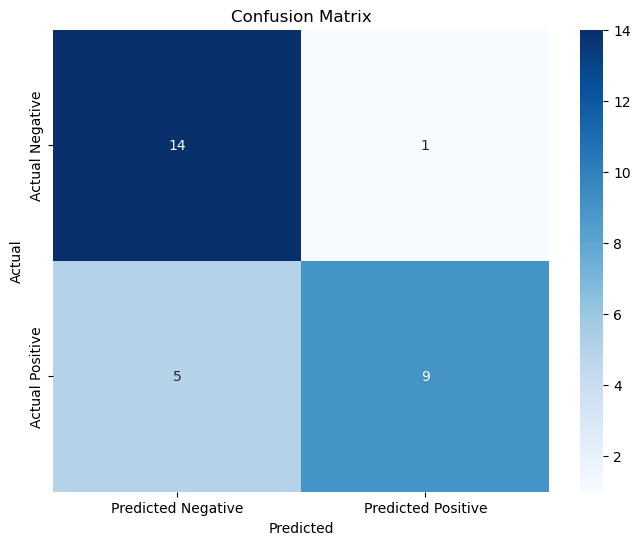

Accuracy: 0.79
Precision: 0.90
Recall (Sensitivity): 0.64
Specificity: 0.93
F1 Score: 0.75


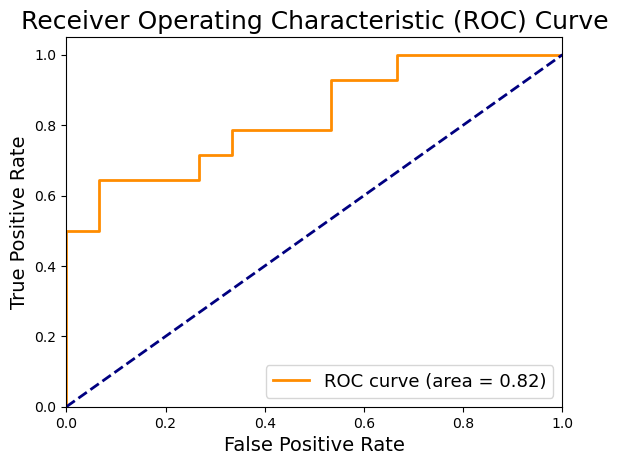

In [31]:
feature_count = 81

df = pd.read_csv(
    f'../Datasets/Dataset07/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()